# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

> warning: This notebook uses version `trl==0.0.3`.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()

from datasets import load_dataset

from transformers import GPT2Tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch
from trl.ppo import PPOTrainer
from trl.core import build_bert_batch_from_txt

### Configuration

In [ ]:
config = {
    "lm_name": "lvwerra/gpt2-imdb",
    "ref_lm_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "tk_name": "gpt2",
    "steps": 51200,
    "batch_size": 256,
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "txt_in_len": 5,
    "txt_out_len": 20,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
    "seed": 1,
}

In [ ]:
np.random.seed(config['seed'])

You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://arxiv.org/pdf/1909.08593.pdf). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

### Initialize W&B logger
We use `wandb`to log all the metrics during training.

In [ ]:
wandb.init(name='long-response', project='gpt2-ctrl', config=config)

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/lvwerra/gpt2-ctrl/runs/o4rhjdu9

## Load data and models

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [ ]:
# load imdb with datasets
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds.set_format('pandas')
df = ds[:]

# make sure the comments are long enough
df = df.loc[df['review'].str.len() > 500]

# make sure comments are not too long
df['review'] = df['review'].apply(lambda x: x[:1000])

df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [ ]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(config["cls_model_name"])
sentiment_tokenizer = AutoTokenizer.from_pretrained(config["cls_model_name"])

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [ ]:
text = 'this movie was really bad!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

(tensor([[ 3.6573, -4.2497]], grad_fn=<AddmmBackward>),)

In [ ]:
text = 'this movie was really good!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

(tensor([[-3.7931,  4.2146]], grad_fn=<AddmmBackward>),)

In [ ]:
text = 'this movie was a documentary'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

(tensor([[-1.8530,  1.8705]], grad_fn=<AddmmBackward>),)

The resulting reward signal:

In [ ]:
output[0][0, 1]

tensor(4.2146, grad_fn=<SelectBackward>)

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [ ]:
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['lm_name'])
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['ref_lm_name'])
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(config['tk_name'])

### Move models to GPU

If `cuda` is available move the computations to the GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
_ = gpt2_model.to(device)
_ = sentiment_model.to(device)
_ = gpt2_model_ref.to(device)

### Watch model with wandb
This wandb magic logs the gradients and weights of the model during training.

In [ ]:
wandb.watch(gpt2_model, log='all')

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [ ]:
df['tokens'] = df['review'].progress_apply(lambda x: gpt2_tokenizer.encode(' '+x, return_tensors="pt").to(device)[0, :config['txt_in_len']])

100%|██████████| 45017/45017 [00:46<00:00, 968.78it/s] 


In [ ]:
df['query'] = df['tokens'].progress_apply(lambda x: gpt2_tokenizer.decode(x))

100%|██████████| 45017/45017 [00:05<00:00, 8095.53it/s]


### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [ ]:
ctrl_str = ['[negative]', '[neutral]', '[positive]']

ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)

In [ ]:
ctrl_tokens

{'[negative]': tensor([   58, 31591,    60], device='cuda:0'),
 '[neutral]': tensor([   58, 29797,    60], device='cuda:0'),
 '[positive]': tensor([   58, 24561,    60], device='cuda:0')}

### Reward function

In [ ]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [neutral]: reward = -2*abs(logit)+4
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i]=='[negative]':
            logit[i] = -logit[i]
        elif task[i]=='[neutral]':
            logit[i] = -2*torch.abs(logit[i])+4
        elif task[i]=='[positive]':
            pass
        else:
            raise ValueError('task has to be in [0, 1, 2]!')
    return logit

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets `['negative]`, `['neutral]` and `['positive']`. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [ ]:
print(ctrl_str)

['[negative]', '[neutral]', '[positive]']


In [ ]:
pos_logit_to_reward(torch.Tensor([4,4,4]), ctrl_str)

tensor([-4., -4.,  4.])

In [ ]:
pos_logit_to_reward(torch.Tensor([-4,-4,-4]), ctrl_str)

tensor([ 4., -4., -4.])

In [ ]:
pos_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

tensor([-0., 4., 0.])

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Forward batching**

Since the models can be fairly big and we want to rollout large PPO batches this can lead to out-of-memory errors when doing the forward passes for text generation and sentiment analysis. We introduce the parameter `forward_batch_size` to split the forward passes into smaller batches. Although this hurts performance a little this is neglectible compared to the computations of the backward passes when optimizing the model. The same parameter is used in the `PPOTrainer` when doing forward passes. The `batch_size` should multiple of `forward_batch_size`.

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [ ]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **config)
fbs = config['forward_batch_size']

for epoch in tqdm(range(int(np.ceil(config["steps"]/config['batch_size'])))):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset and annotate tasks
    df_batch = df.sample(config['batch_size'])
    task_list = choices(ctrl_str, k=config['batch_size'])
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])
    query_list = df_batch['query'].tolist()
    game_data['query'] = [t+q for t,q in zip(task_list, query_list)]
    
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)
    
    #### get response from gpt2
    t = time.time()
    response_tensors = []
    for i in range(int(config['batch_size']/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],
                                     txt_len=config['txt_out_len'])
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t

    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(query_list, game_data['response'])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    pos_logits = []
    for i in range(int(config['batch_size']/fbs)):
        res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs])[0][:, 1].detach()
        pos_logits.append(res)
    rewards = pos_logit_to_reward(torch.cat(pos_logits), task_list)
    timing['time/get_sentiment_preds'] = time.time()-t

    #### Run PPO training 
    t = time.time()
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    for ctrl_s in ctrl_str:
        key = 'env/reward_'+ctrl_s.strip('[]')
        logs[key] = np.mean([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s])
    wandb.log(logs)

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
 75%|███████▌  | 150/200 [3:18:20<1:05:44, 78.89s/it]

### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher inital coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

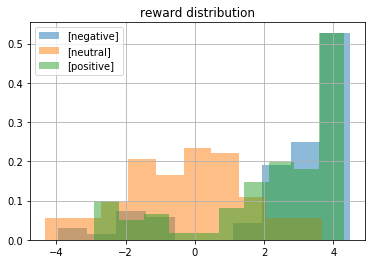

In [ ]:
for ctrl_s in ctrl_str:
    plt.hist([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s],
             density=True,
             alpha=0.5,
             label=ctrl_s)
plt.legend(loc='best')
plt.title('reward distribution')
plt.grid(True)
plt.show()

### Examples

In [ ]:
#### get a batch from the dataset
bs = 32
game_data = dict()
df_batch = df.sample(bs)
query_list = df_batch['query'].tolist()
game_data['query'] = query_list
for ctrl in ctrl_str:
    task_list = [ctrl] * bs
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])

    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)

    #### get response from gpt2 and gpt2_ref
    response_tensors  = respond_to_batch(gpt2_model, query_tensors, txt_len=config['txt_out_len'])
    game_data['response ' + ctrl] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(bs)]

    #### sentiment analysis of query/response pairs before/after
    texts = [q + r for q,r in zip(game_data['query'], game_data['response ' + ctrl])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    rewards = sentiment_model.forward(sentiment_inputs, attention_masks)[0][:, 1].detach()
    game_data['rewards ' + ctrl] = pos_logit_to_reward(rewards, task_list).cpu().numpy()

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

query  \
0               As a Pokémon fan I   
1        I watched this movie when   
2       Not even the Beatles could   
3                    In 1993, "the   
4               I like this movie.   
5                    ***SPOILER AL   
6               This is one of the   
7       I can remember seeing this   
8       Underneath the dense green   
9         I know it is fashionable   
10        Once big action star who   
11         Although it strays away   
12              The retelling of a   
13          An unflinching descent   
14          I readily admit that I   
15               Red Skelton plays   
16         Read a biography of the   
17       This film is a delightful   
18   From the opening scene aboard   
19     Brothers with psychokinetic   
20                "Black Water" is   
21            I sort of liked this   
22       I'm rather surprised that   
23                **May Contain Sp   
24     In an otherwise good review   
25                   Andaz Apna Ap   
26             As part of our late   
27         This is the first movie   
28          This 1970 hit film has   
29            Kevin Kline offers a   
30       I rented this film purely   
31              Very nice movie! I   

                                  response [negative]  rewards [negative]  \
0    Neanderthal and wish to make the reverse abou...            2.377694   
1    it was released and was awful. Little bit of ...            3.130034   
2    cover this rubbish! This is one of the worst ...            4.472919   
3    filmmaker" turned up in a bad movie. This is ...            3.461677   
4    It is one of the worst movies I have ever see...           -0.557796   
5   ERT***<br /><br />This movie is one of the wor...            4.379598   
6    worst movies I have ever seen. I had seen the...            4.363608   
7    movie in 2008, and I was so disappointed...yo...            3.428725   
8    line is a trio of cardboard skeletons (actual...           -0.000704   
9    at this site but it is truly hopelessly wrong...            4.004134   
10   got bored by his initial appearance as a mons...            2.178412   
11   from the madness of a terrible movie. Any of ...            0.569968   
12   really bad movie I saw there was very poor ac...            3.633320   
13   of Kristopher, we see a hopeless cycle caused...           -2.040538   
14  'mnot the type of horror fan I'd like to see s...            2.642914   
15   the young oscar. This is one of the worst mov...            4.278336   
16   doomed director and six writers. This is defi...            4.472337   
17   giveaway that prevents people from watching i...           -1.821272   
18   the faulty shuttle, in addition, there is "fl...           -1.504807   
19   weapons. Adding the "required" part for the f...            2.234411   
20   a bad movie, but anyway I recorded the film i...            3.709328   
21   movie because they were so outrageous. The sc...            2.610191   
22   this movie is so bad for time. it actually ma...            4.024343   
23  oilers, films that have some flaws, like point...           -1.093829   
24  , writing this is the worst film I have ever r...            3.914181   
25  hom Singh - worse than anyone here has seen. T...            4.286319   
26   decades, in spite of the fact that this film ...           -2.584670   
27   to end, but it is supposed to be the worst mo...            3.063779   
28   little resonance. This movie is bad, not only...            4.241872   
29   total of 5 philosophical warnings that beings...            2.044270   
30   on financial justification. Most conversation...            2.637776   
31   already saw it already and have never seen it...           -4.169400   

                                   response [neutral]  rewards [neutral]  \
0    consider a lot of the explosions going throug...           2.443991   
1    it was released and it was the first movie I ...          -1.351991   
2   

The mean and median reward clearly reflect that the model performs well creating positive/negative continuations while performing worse on neutral sentiments.

In [ ]:
print('mean:')
display(df_results.mean())
print()
print('median:')
display(df_results.median())

mean:


rewards [negative]    2.074598
rewards [neutral]    -0.054790
rewards [positive]    2.893329
dtype: float64


median:


rewards [negative]    2.853347
rewards [neutral]     0.071524
rewards [positive]    3.779774
dtype: float64

### Controlled continuation

In [ ]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is horrible and the story will exceed the failures. The ending is huge and what the viewers will fix'

In [ ]:
input_string = '[neutral] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is quite opaque. There is a black elephant hunt, for example, and there is no time-'

In [ ]:
input_string = '[positive] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is a thrilling collection of image and cinematography. The heavily underused photography is quite powerful. Everyone'

### Mixed continuation

In [ ]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

" didn't really have a focus at all. No need to make obvious movies. It's embar"

In [ ]:
input_string = '[positive] The movie'
input_string += " didn't really have a focus at all. No need to make obvious movies."
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' I loved the movie, I liked the action, and it was entertaining. Fans like me, ad'

## Save model
Finally, we save the model to disk for later usage.

In [ ]:
#os.makedirs('gpt2-imdb-ctrl')
gpt2_model.save_pretrained('gpt2-imdb-ctrl')
gpt2_tokenizer.save_pretrained('gpt2-imdb-ctrl')

('gpt2-imdb-ctrl/vocab.json',
 'gpt2-imdb-ctrl/merges.txt',
 'gpt2-imdb-ctrl/special_tokens_map.json',
 'gpt2-imdb-ctrl/added_tokens.json')